## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [12]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [13]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [14]:
# Model settings
modelName = 'stockScreenerV1.7'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'DRS'  # 'ALL' for all, 'amount%', 'None' for no prediction

# Training parameters
trainingSize = 1200  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 256
epochs = 30

# Testing parameters
testSize = 400  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [15]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [16]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [17]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [18]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [19]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [20]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

Processing TESS...


$TESS: possibly delisted; no timezone found


No data found for TESS (10y)
Skipped TESS - insufficient data
Processing VGIT...


$CHC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CHC...
No data found for CHC (10y)
Skipped CHC - insufficient data
Processing IPDN...
Processing CFB...
Processing CZWI...
Processing EFF...


$EFF: possibly delisted; no timezone found


No data found for EFF (10y)
Skipped EFF - insufficient data
Processing BML-I...


$BML-I: possibly delisted; no timezone found


No data found for BML-I (10y)
Skipped BML-I - insufficient data
Processing CPLP...


$CPLP: possibly delisted; no timezone found


No data found for CPLP (10y)
Skipped CPLP - insufficient data
Processing HIO...


$ARX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ARX...
No data found for ARX (10y)
Skipped ARX - insufficient data
Processing SURG...
Processing CPIX...


$FMER: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$BKMU: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing FMER...
No data found for FMER (10y)
Skipped FMER - insufficient data
Processing BKMU...
No data found for BKMU (10y)
Skipped BKMU - insufficient data
Processing CEB...
Insufficient data for CEB (195 rows)
Skipped CEB - insufficient data
Processing PLXS...


$ONNN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ONNN...
No data found for ONNN (10y)
Skipped ONNN - insufficient data
Processing NCR...


$NCR: possibly delisted; no timezone found
$WFD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NCR (10y)
Skipped NCR - insufficient data
Processing WFD...
No data found for WFD (10y)
Skipped WFD - insufficient data
Processing PBY...
Processing MTG...
Processing CIB...
Processing JOE...
Processing ACGL...
Processing AEB...


$ARMH: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ARMH...
No data found for ARMH (10y)
Skipped ARMH - insufficient data
Processing SSNC...
Processing BUSE...
Processing TTGT...
Processing NUW...
Processing LXFT...


$LXFT: possibly delisted; no timezone found
$MENT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for LXFT (10y)
Skipped LXFT - insufficient data
Processing MENT...
No data found for MENT (10y)
Skipped MENT - insufficient data
Processing TYN...


$TYN: possibly delisted; no timezone found


No data found for TYN (10y)
Skipped TYN - insufficient data
Processing CVCO...
Processing ARP...
Processing KSU.P...
Processing PCF...
Processing JNJ...
Processing VIFL...
Insufficient data for VIFL (28 rows)
Skipped VIFL - insufficient data
Processing SMBC...


$SBW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SBW...
No data found for SBW (10y)
Skipped SBW - insufficient data
Processing TWI...
Processing NUV...
Processing STL...


$STL: possibly delisted; no timezone found


No data found for STL (10y)
Skipped STL - insufficient data
Processing TEP...


$UNIS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing UNIS...
No data found for UNIS (10y)
Skipped UNIS - insufficient data
Processing MSON...


$MSON: possibly delisted; no timezone found


No data found for MSON (10y)
Skipped MSON - insufficient data
Processing IFN...


$HOLL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$PPP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HOLL...
No data found for HOLL (10y)
Skipped HOLL - insufficient data
Processing PPP...
No data found for PPP (10y)
Skipped PPP - insufficient data
Processing RNDY...


$RNDY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RNDY (10y)
Skipped RNDY - insufficient data
Processing CYTXW...


$CYTXW: possibly delisted; no timezone found


No data found for CYTXW (10y)
Skipped CYTXW - insufficient data
Processing AHH...
Processing ABCD...
Processing AOD...
Processing PX...
Processing SPG-J...


$SPG-J: possibly delisted; no timezone found


No data found for SPG-J (10y)
Skipped SPG-J - insufficient data
Processing HCS-B...


$HCS-B: possibly delisted; no timezone found


No data found for HCS-B (10y)
Skipped HCS-B - insufficient data
Processing RFI...
Processing INXN...


$INXN: possibly delisted; no timezone found


No data found for INXN (10y)
Skipped INXN - insufficient data
Processing RGP...
Processing GASS...
Processing UBS-D...


$UBS-D: possibly delisted; no timezone found


No data found for UBS-D (10y)
Skipped UBS-D - insufficient data
Processing GSOL...
Insufficient data for GSOL (267 rows)
Skipped GSOL - insufficient data
Processing CXO...


$CXO: possibly delisted; no timezone found


No data found for CXO (10y)
Skipped CXO - insufficient data
Processing ASG...
Processing FSLR...
Processing VGSH...


$LBF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$NMRX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LBF...
No data found for LBF (10y)
Skipped LBF - insufficient data
Processing NMRX...
No data found for NMRX (10y)
Skipped NMRX - insufficient data
Processing NVAX...
Processing TEI...
Processing NLST...
Processing CPHC...


$FCZA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing FCZA...
No data found for FCZA (10y)
Skipped FCZA - insufficient data
Processing FOXA...
Processing PSB-S...


$PSB-S: possibly delisted; no timezone found
$CPHD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PSB-S (10y)
Skipped PSB-S - insufficient data
Processing CPHD...
No data found for CPHD (10y)
Skipped CPHD - insufficient data
Processing HAR...
Processing BCPC...
Processing FCCO...
Processing MER-E...


$MER-E: possibly delisted; no timezone found


No data found for MER-E (10y)
Skipped MER-E - insufficient data
Processing NXPI...
Processing GOODP...


$GOODP: possibly delisted; no timezone found
$PBNY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for GOODP (10y)
Skipped GOODP - insufficient data
Processing PBNY...
No data found for PBNY (10y)
Skipped PBNY - insufficient data
Processing AHT-PA...


$AHT-PA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ARN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for AHT-PA (10y)
Skipped AHT-PA - insufficient data
Processing ARN...
No data found for ARN (10y)
Skipped ARN - insufficient data
Processing VTWO...
Processing LUNA...
Processing DUKH...
Insufficient data for DUKH (136 rows)
Skipped DUKH - insufficient data
Processing JBLU...


$PCLN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PCLN...
No data found for PCLN (10y)
Skipped PCLN - insufficient data
Processing PGEM...
Processing THTI...


$THTI: possibly delisted; no timezone found


No data found for THTI (10y)
Skipped THTI - insufficient data
Processing JPM-I...


$JPM-I: possibly delisted; no timezone found


No data found for JPM-I (10y)
Skipped JPM-I - insufficient data
Processing MTB.P...
Processing IN...
Processing FBC...


$FBC: possibly delisted; no timezone found
$CNBC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for FBC (10y)
Skipped FBC - insufficient data
Processing CNBC...
No data found for CNBC (10y)
Skipped CNBC - insufficient data
Processing THO...
Processing NGVC...
Processing KSS...
Processing ACI...
Processing RMTI...
Processing CPRX...
Processing ARW...
Processing BCC...
Processing CYS-A...


$CYS-A: possibly delisted; no timezone found


No data found for CYS-A (10y)
Skipped CYS-A - insufficient data
Processing GXP-A...


$GXP-A: possibly delisted; no timezone found
$HW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for GXP-A (10y)
Skipped GXP-A - insufficient data
Processing HW...
No data found for HW (10y)
Skipped HW - insufficient data
Processing WYNN...
Processing GEK...


$GEK: possibly delisted; no timezone found


No data found for GEK (10y)
Skipped GEK - insufficient data
Processing IIIN...
Processing JMBA...
Processing BKSC...
Processing SB-B...


$SB-B: possibly delisted; no timezone found


No data found for SB-B (10y)
Skipped SB-B - insufficient data
Processing MCBC...


$MCBC: possibly delisted; no timezone found


No data found for MCBC (10y)
Skipped MCBC - insufficient data
Processing IPAR...
Processing GSE...


$KIOR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KIOR...
No data found for KIOR (10y)
Skipped KIOR - insufficient data
Processing HCKT...
Processing WSBC...
Processing TECH...
Processing FUR-D...


$FUR-D: possibly delisted; no timezone found


No data found for FUR-D (10y)
Skipped FUR-D - insufficient data
Processing CAMT...
Processing RDNT...
Processing SHI...


$SHI: possibly delisted; no timezone found
$GSF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for SHI (10y)
Skipped SHI - insufficient data
Processing GSF...
No data found for GSF (10y)
Skipped GSF - insufficient data
Processing SLB...
Processing UFI...
Processing PRCP...


$PRCP: possibly delisted; no timezone found


No data found for PRCP (10y)
Skipped PRCP - insufficient data
Processing NVMI...


$WRES: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing WRES...
No data found for WRES (10y)
Skipped WRES - insufficient data
Processing CHU...


$CHU: possibly delisted; no timezone found


No data found for CHU (10y)
Skipped CHU - insufficient data
Processing RTEC...


$RTEC: possibly delisted; no timezone found


No data found for RTEC (10y)
Skipped RTEC - insufficient data
Processing IMGN...


$IMGN: possibly delisted; no timezone found


No data found for IMGN (10y)
Skipped IMGN - insufficient data
Processing I-A...


$I-A: possibly delisted; no timezone found


No data found for I-A (10y)
Skipped I-A - insufficient data
Processing BRKL...
Processing GRX-A...


$GRX-A: possibly delisted; no timezone found


No data found for GRX-A (10y)
Skipped GRX-A - insufficient data
Processing GCI...
Processing BPOP...
Processing GIFI...


$LRY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LRY...
No data found for LRY (10y)
Skipped LRY - insufficient data
Processing IMKTA...


$CGI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CGI...
No data found for CGI (10y)
Skipped CGI - insufficient data
Processing ONFC...


$ONFC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ONFC (10y)
Skipped ONFC - insufficient data
Processing SXE...


$SXE: possibly delisted; no timezone found


No data found for SXE (10y)
Skipped SXE - insufficient data
Processing DX-B...


$DX-B: possibly delisted; no timezone found
$ASDR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DX-B (10y)
Skipped DX-B - insufficient data
Processing ASDR...
No data found for ASDR (10y)
Skipped ASDR - insufficient data
Processing BXP...
Processing EQM...


$EQM: possibly delisted; no timezone found


No data found for EQM (10y)
Skipped EQM - insufficient data
Processing CHMT...


$CHMT: possibly delisted; no timezone found
$MIL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CHMT (10y)
Skipped CHMT - insufficient data
Processing MIL...
No data found for MIL (10y)
Skipped MIL - insufficient data
Processing RGR...
Processing CY...


$CY: possibly delisted; no timezone found


No data found for CY (10y)
Skipped CY - insufficient data
Processing NDAQ...
Processing TISA...


$TISA: possibly delisted; no timezone found


No data found for TISA (10y)
Skipped TISA - insufficient data
Processing UNP...
Processing UBP-D...


$UBP-D: possibly delisted; no timezone found


No data found for UBP-D (10y)
Skipped UBP-D - insufficient data
Processing HR...
Processing GLUU...


$GLUU: possibly delisted; no timezone found


No data found for GLUU (10y)
Skipped GLUU - insufficient data
Processing NIM...
Processing SNX...


$ENL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ENL...
No data found for ENL (10y)
Skipped ENL - insufficient data
Processing RHT...


$RHT: possibly delisted; no timezone found


No data found for RHT (10y)
Skipped RHT - insufficient data
Processing LPSN...


$VOCS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VOCS...
No data found for VOCS (10y)
Skipped VOCS - insufficient data
Processing ZLTQ...


$ZLTQ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$JFBI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ZLTQ (10y)
Skipped ZLTQ - insufficient data
Processing JFBI...
No data found for JFBI (10y)
Skipped JFBI - insufficient data
Processing EEME...
Processing EVER...


$PEOP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ESD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PEOP...
No data found for PEOP (10y)
Skipped PEOP - insufficient data
Processing ESD...
No data found for ESD (10y)
Skipped ESD - insufficient data
Processing MOLXA...


$MOLXA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MOLXA (10y)
Skipped MOLXA - insufficient data
Processing SUNS...
Insufficient data for SUNS (138 rows)
Skipped SUNS - insufficient data
Processing SMTX...


$SMTX: possibly delisted; no timezone found


No data found for SMTX (10y)
Skipped SMTX - insufficient data
Processing GES...
Processing RELV...
Processing RPRXZ...


$RPRXZ: possibly delisted; no timezone found


No data found for RPRXZ (10y)
Skipped RPRXZ - insufficient data
Processing ICCC...
Processing AEP...
Processing AKO.A...


$AKO.A: possibly delisted; no timezone found


No data found for AKO.A (10y)
Skipped AKO.A - insufficient data
Processing TDI...
Insufficient data for TDI (279 rows)
Skipped TDI - insufficient data
Processing POR...
Processing DHIL...
Processing BCSB...
Insufficient data for BCSB (15 rows)
Skipped BCSB - insufficient data
Processing M...
Processing XOM...


$IDIX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IDIX...
No data found for IDIX (10y)
Skipped IDIX - insufficient data
Processing PLCE...


$LCC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LCC...
No data found for LCC (10y)
Skipped LCC - insufficient data
Processing SAFT...
Processing PYC...


$IL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IL...
No data found for IL (10y)
Skipped IL - insufficient data
Processing HSB-B...


$HSB-B: possibly delisted; no timezone found
$JBO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HSB-B (10y)
Skipped HSB-B - insufficient data
Processing JBO...
No data found for JBO (10y)
Skipped JBO - insufficient data
Processing AAT...
Processing JE...


$JE: possibly delisted; no timezone found


No data found for JE (10y)
Skipped JE - insufficient data
Processing PFN...
Processing QIWI...
Processing MPG-A...


$MPG-A: possibly delisted; no timezone found
$BRCM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MPG-A (10y)
Skipped MPG-A - insufficient data
Processing BRCM...
No data found for BRCM (10y)
Skipped BRCM - insufficient data
Processing NSIT...
Processing HSTM...
Processing APF...


$APF: possibly delisted; no timezone found
$BONT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for APF (10y)
Skipped APF - insufficient data
Processing BONT...
No data found for BONT (10y)
Skipped BONT - insufficient data
Processing FSCI...
Processing CNQ...
Processing HTCO...
Processing CIS...
Processing ALU...
Insufficient data for ALU (196 rows)
Skipped ALU - insufficient data
Processing GARS...


$GARS: possibly delisted; no timezone found


No data found for GARS (10y)
Skipped GARS - insufficient data
Processing AU...
Processing EXEL...
Processing CRD.B...


$CRD.B: possibly delisted; no timezone found
$ANLY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CRD.B (10y)
Skipped CRD.B - insufficient data
Processing ANLY...
No data found for ANLY (10y)
Skipped ANLY - insufficient data
Processing STK...
Processing ENDP...


$ENDP: possibly delisted; no timezone found


No data found for ENDP (10y)
Skipped ENDP - insufficient data
Processing FC...
Processing CVLT...
Processing BRKS...


$BRKS: possibly delisted; no timezone found


No data found for BRKS (10y)
Skipped BRKS - insufficient data
Processing EE...


$XRSC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing XRSC...
No data found for XRSC (10y)
Skipped XRSC - insufficient data
Processing LBTYA...
Processing PERI...
Processing SDLP...


$SDLP: possibly delisted; no timezone found


No data found for SDLP (10y)
Skipped SDLP - insufficient data
Processing OABC...


$FAV: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Insufficient data for OABC (220 rows)
Skipped OABC - insufficient data
Processing FAV...
No data found for FAV (10y)
Skipped FAV - insufficient data
Processing WVVI...
Processing CSV...
Processing ETV...


$BGSC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BGSC...
No data found for BGSC (10y)
Skipped BGSC - insufficient data
Processing DHT...
Processing SCE-F...


$SCE-F: possibly delisted; no timezone found


No data found for SCE-F (10y)
Skipped SCE-F - insufficient data
Processing MGF...
Processing GNE...
Processing CAH...
Processing LKFN...


$NNP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing NNP...
No data found for NNP (10y)
Skipped NNP - insufficient data
Processing DTE...
Processing RCII...


$RCII: possibly delisted; no timezone found


No data found for RCII (10y)
Skipped RCII - insufficient data
Processing KOF...
Processing TEVA...
Processing DNKN...


$DNKN: possibly delisted; no timezone found
$CVB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DNKN (10y)
Skipped DNKN - insufficient data
Processing CVB...
No data found for CVB (10y)
Skipped CVB - insufficient data
Processing GCOM...
Processing NLY-C...


$NLY-C: possibly delisted; no timezone found


No data found for NLY-C (10y)
Skipped NLY-C - insufficient data
Processing SAQ...


$SAQ: possibly delisted; no timezone found


No data found for SAQ (10y)
Skipped SAQ - insufficient data
Processing OPY...
Processing NSM...


$CWZ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CWZ...
No data found for CWZ (10y)
Skipped CWZ - insufficient data
Processing XRAY...
Processing MFA...


$HME: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HME...
No data found for HME (10y)
Skipped HME - insufficient data
Processing BDSI...


$BDSI: possibly delisted; no timezone found


No data found for BDSI (10y)
Skipped BDSI - insufficient data
Processing NAUH...
Processing CBNK...
Processing BKI...


$BKI: possibly delisted; no timezone found


No data found for BKI (10y)
Skipped BKI - insufficient data
Processing GIGM...


$UNS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing UNS...
No data found for UNS (10y)
Skipped UNS - insufficient data
Processing SRF...


$SRF: possibly delisted; no timezone found


No data found for SRF (10y)
Skipped SRF - insufficient data
Processing SGZA...


$SGZA: possibly delisted; no timezone found


No data found for SGZA (10y)
Skipped SGZA - insufficient data
Processing BML-L...


$BML-L: possibly delisted; no timezone found


No data found for BML-L (10y)
Skipped BML-L - insufficient data
Processing PHG...
Processing MEIL...


$SPPR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SPPR...
No data found for SPPR (10y)
Skipped SPPR - insufficient data
Processing AL...
Processing EXLS...
Processing ALV...


$TLAB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing TLAB...
No data found for TLAB (10y)
Skipped TLAB - insufficient data
Processing JW.A...


$JW.A: possibly delisted; no timezone found


No data found for JW.A (10y)
Skipped JW.A - insufficient data
Processing CISAW...


$CISAW: possibly delisted; no timezone found
$EOPN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CISAW (10y)
Skipped CISAW - insufficient data
Processing EOPN...
No data found for EOPN (10y)
Skipped EOPN - insufficient data
Processing MDR...


$MDR: possibly delisted; no timezone found


No data found for MDR (10y)
Skipped MDR - insufficient data
Processing EBS...


$GSJK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GSJK...
No data found for GSJK (10y)
Skipped GSJK - insufficient data
Processing SFI-F...


$SFI-F: possibly delisted; no timezone found


No data found for SFI-F (10y)
Skipped SFI-F - insufficient data
Processing CWST...
Processing RENT...
Processing SQQQ...
Processing JACK...


$DRWI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$EFM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing DRWI...
No data found for DRWI (10y)
Skipped DRWI - insufficient data
Processing EFM...
No data found for EFM (10y)
Skipped EFM - insufficient data
Processing AROW...


$PRXL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PRXL...
No data found for PRXL (10y)
Skipped PRXL - insufficient data
Processing PEO...
Processing LSE...
Insufficient data for LSE (23 rows)
Skipped LSE - insufficient data
Processing GM-B...


$GM-B: possibly delisted; no timezone found


No data found for GM-B (10y)
Skipped GM-B - insufficient data
Processing RDN...
Processing LVS...
Processing SYT...


$GFIG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GFIG...
No data found for GFIG (10y)
Skipped GFIG - insufficient data
Processing MCRI...
Processing HYLS...
Processing MTSC...


$MTSC: possibly delisted; no timezone found


No data found for MTSC (10y)
Skipped MTSC - insufficient data
Processing MOD...
Processing SFI-G...


$SFI-G: possibly delisted; no timezone found


No data found for SFI-G (10y)
Skipped SFI-G - insufficient data
Processing OSUR...
Processing BZH...


$MHGC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MHGC...
No data found for MHGC (10y)
Skipped MHGC - insufficient data
Processing ITW...
Processing THC...
Processing GNE-A...


$GNE-A: possibly delisted; no timezone found


No data found for GNE-A (10y)
Skipped GNE-A - insufficient data
Processing PETS...
Processing BUI...


$LCAV: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$GEF.B: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LCAV...
No data found for LCAV (10y)
Skipped LCAV - insufficient data
Processing GEF.B...
No data found for GEF.B (10y)
Skipped GEF.B - insufficient data
Processing TXCC...


$TXCC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TXCC (10y)
Skipped TXCC - insufficient data
Processing SANM...


$SWFT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MLU...
Insufficient data for MLU (5 rows)
Skipped MLU - insufficient data
Processing SWFT...
No data found for SWFT (10y)
Skipped SWFT - insufficient data
Processing PAM...
Processing DSWL...
Processing FCFS...
Processing JBN...


$JBN: possibly delisted; no timezone found
$RUE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for JBN (10y)
Skipped JBN - insufficient data
Processing RUE...
No data found for RUE (10y)
Skipped RUE - insufficient data
Processing SVBI...


$SVBI: possibly delisted; no timezone found


No data found for SVBI (10y)
Skipped SVBI - insufficient data
Processing RDHL...
Processing IFSM...


$IFSM: possibly delisted; no timezone found
$VLTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for IFSM (10y)
Skipped IFSM - insufficient data
Processing VLTR...
No data found for VLTR (10y)
Skipped VLTR - insufficient data
Processing CHXF...
No data found for CHXF (10y)
Skipped CHXF - insufficient data
Processing BLMT...


$BLMT: possibly delisted; no timezone found
$MAXY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$FDI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BLMT (10y)
Skipped BLMT - insufficient data
Processing MAXY...
No data found for MAXY (10y)
Skipped MAXY - insufficient data
Processing FDI...
No data found for FDI (10y)
Skipped FDI - insufficient data
Processing AXL...
Processing RGDO...


$RGDO: possibly delisted; no timezone found


No data found for RGDO (10y)
Skipped RGDO - insufficient data
Processing DQ...


$EAA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing EAA...
No data found for EAA (10y)
Skipped EAA - insufficient data
Processing AMBA...
Processing BLIN...
Processing KVHI...
Processing SIBC...
Processing DKS...
Processing EPD...


$CRMB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CRMB...
No data found for CRMB (10y)
Skipped CRMB - insufficient data
Processing DISCB...


$DISCB: possibly delisted; no timezone found


No data found for DISCB (10y)
Skipped DISCB - insufficient data
Processing OIA...
Processing PNFP...
Processing MNGA...


$MNGA: possibly delisted; no timezone found


No data found for MNGA (10y)
Skipped MNGA - insufficient data
Processing TCC...


$LMCB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LMCB...
No data found for LMCB (10y)
Skipped LMCB - insufficient data
Processing CEO...


$CEO: possibly delisted; no timezone found
$LIOX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CEO (10y)
Skipped CEO - insufficient data
Processing LIOX...
No data found for LIOX (10y)
Skipped LIOX - insufficient data
Processing AXS-C...


$AXS-C: possibly delisted; no timezone found


No data found for AXS-C (10y)
Skipped AXS-C - insufficient data
Processing MAC...
Processing ULTI...


$ULTI: possibly delisted; no timezone found


No data found for ULTI (10y)
Skipped ULTI - insufficient data
Processing CLX...
Processing GURE...
Processing BIF...


$BIF: possibly delisted; no timezone found


No data found for BIF (10y)
Skipped BIF - insufficient data
Processing SPNS...
Processing IRDMZ...


$IRDMZ: possibly delisted; no timezone found


No data found for IRDMZ (10y)
Skipped IRDMZ - insufficient data
Processing SFLY...


$SFLY: possibly delisted; no timezone found


No data found for SFLY (10y)
Skipped SFLY - insufficient data
Processing ARR-A...


$ARR-A: possibly delisted; no timezone found


No data found for ARR-A (10y)
Skipped ARR-A - insufficient data
Processing LYB...
Processing NEOG...
Processing NXN...
Processing CARZ...
Processing BEAT...
Processing MIDD...
Processing KRO...
Processing SKYW...
Processing CTIC...


$CTIC: possibly delisted; no timezone found


No data found for CTIC (10y)
Skipped CTIC - insufficient data
Processing EPR-E...


$EPR-E: possibly delisted; no timezone found


No data found for EPR-E (10y)
Skipped EPR-E - insufficient data
Processing OSTK...
Insufficient data for OSTK (1 rows)
Skipped OSTK - insufficient data
Processing OAKS...


$OAKS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for OAKS (10y)
Skipped OAKS - insufficient data
Processing CAC...
Processing EHI...
Processing PRTS...
Processing GRFS...
Processing NEV...


$NEV: possibly delisted; no timezone found
$TLLP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NEV (10y)
Skipped NEV - insufficient data
Processing TLLP...
No data found for TLLP (10y)
Skipped TLLP - insufficient data
Processing ASX...
Processing MFNC...


$MFNC: possibly delisted; no timezone found


No data found for MFNC (10y)
Skipped MFNC - insufficient data
Processing DXB...


$DXB: possibly delisted; no timezone found


No data found for DXB (10y)
Skipped DXB - insufficient data
Processing CPLA...


$ISH: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$NNJ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ISH...
No data found for ISH (10y)
Skipped ISH - insufficient data
Processing NNJ...
No data found for NNJ (10y)
Skipped NNJ - insufficient data
Processing PRIM...
Processing EHTH...


$LTON: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LTON...
No data found for LTON (10y)
Skipped LTON - insufficient data
Processing MLI...
Processing DGLY...
Processing DFT-A...


$DFT-A: possibly delisted; no timezone found


No data found for DFT-A (10y)
Skipped DFT-A - insufficient data
Processing HOS...


$HOS: possibly delisted; no timezone found
$PSEM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HOS (10y)
Skipped HOS - insufficient data
Processing PSEM...
No data found for PSEM (10y)
Skipped PSEM - insufficient data
Processing PRPH...
Processing KTP...


$KTP: possibly delisted; no timezone found


No data found for KTP (10y)
Skipped KTP - insufficient data
Processing OC.B...


$OC.B: possibly delisted; no timezone found


No data found for OC.B (10y)
Skipped OC.B - insufficient data
Processing PHA...
Insufficient data for PHA (194 rows)
Skipped PHA - insufficient data
Processing PPS-A...


$PPS-A: possibly delisted; no timezone found
$MBRG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PPS-A (10y)
Skipped PPS-A - insufficient data
Processing MBRG...
No data found for MBRG (10y)
Skipped MBRG - insufficient data
Processing SNCR...
Processing ARI-A...


$ARI-A: possibly delisted; no timezone found


No data found for ARI-A (10y)
Skipped ARI-A - insufficient data
Processing EA...
Processing HDSN...


$ENI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ENI...
No data found for ENI (10y)
Skipped ENI - insufficient data
Processing ECOL...


$ECOL: possibly delisted; no timezone found


No data found for ECOL (10y)
Skipped ECOL - insufficient data
Processing KYN...
Processing SB...


$MWIV: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MWIV...
No data found for MWIV (10y)
Skipped MWIV - insufficient data
Processing KW...
Processing FRC...


$FRC: possibly delisted; no timezone found


No data found for FRC (10y)
Skipped FRC - insufficient data
Processing HASI...
Processing ZF...
Processing AMRC...
Processing MPLX...
Processing AMSWA...


$AMSWA: possibly delisted; no timezone found


No data found for AMSWA (10y)
Skipped AMSWA - insufficient data
Processing KONA...


$KONA: possibly delisted; no timezone found


No data found for KONA (10y)
Skipped KONA - insufficient data
Processing TVE...


$BIE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BIE...
No data found for BIE (10y)
Skipped BIE - insufficient data
Processing IPCC...
Processing DENN...
Processing KAMN...


$KAMN: possibly delisted; no timezone found


No data found for KAMN (10y)
Skipped KAMN - insufficient data
Processing KKR...
Processing LOGM...


$LOGM: possibly delisted; no timezone found


No data found for LOGM (10y)
Skipped LOGM - insufficient data
Processing SSD...
Processing NLSN...


$NLSN: possibly delisted; no timezone found


No data found for NLSN (10y)
Skipped NLSN - insufficient data
Processing USATZ...
Processing EOG...
Processing ALB...
Processing LIN...
Processing PFK...


$PFK: possibly delisted; no timezone found


No data found for PFK (10y)
Skipped PFK - insufficient data
Processing ACNB...
Processing SZC...


$SZC: possibly delisted; no timezone found


No data found for SZC (10y)
Skipped SZC - insufficient data
Processing FRX...


$FRX: possibly delisted; no timezone found


No data found for FRX (10y)
Skipped FRX - insufficient data
Processing NRT...
Processing MX...
Processing AMSC...
Processing CYTR...


$CYTR: possibly delisted; no timezone found
$ARSD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CYTR (10y)
Skipped CYTR - insufficient data
Processing ARSD...
No data found for ARSD (10y)
Skipped ARSD - insufficient data
Processing NCT-B...


$NCT-B: possibly delisted; no timezone found


No data found for NCT-B (10y)
Skipped NCT-B - insufficient data
Processing LSE-A...


$LSE-A: possibly delisted; no timezone found


No data found for LSE-A (10y)
Skipped LSE-A - insufficient data
Processing XLNX...


$XLNX: possibly delisted; no timezone found


No data found for XLNX (10y)
Skipped XLNX - insufficient data
Processing FAF...


$ALDW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$KIPO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ALDW...
No data found for ALDW (10y)
Skipped ALDW - insufficient data
Processing KIPO...
No data found for KIPO (10y)
Skipped KIPO - insufficient data
Processing AEIS...
Processing TWO...
Processing BNS...
Processing AIW...


$AIW: possibly delisted; no timezone found


No data found for AIW (10y)
Skipped AIW - insufficient data
Processing SPH...


$PTNT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PTNT...
No data found for PTNT (10y)
Skipped PTNT - insufficient data
Processing DFS...
Processing PDLI...


$PDLI: possibly delisted; no timezone found


No data found for PDLI (10y)
Skipped PDLI - insufficient data
Processing IDT...
Processing OTEL...


$OTEL: possibly delisted; no timezone found


No data found for OTEL (10y)
Skipped OTEL - insufficient data
Processing SBR...
Processing LYG-A...


$LYG-A: possibly delisted; no timezone found


No data found for LYG-A (10y)
Skipped LYG-A - insufficient data
Processing ASCMA...


$ASCMA: possibly delisted; no timezone found


No data found for ASCMA (10y)
Skipped ASCMA - insufficient data
Processing C-R...


$C-R: possibly delisted; no timezone found


No data found for C-R (10y)
Skipped C-R - insufficient data
Processing RIO...
Processing CAMP...
Insufficient data for CAMP (71 rows)
Skipped CAMP - insufficient data
Processing DMRC...
Processing ESL...


$ESL: possibly delisted; no timezone found


No data found for ESL (10y)
Skipped ESL - insufficient data
Processing NXTM...


$NXTM: possibly delisted; no timezone found


No data found for NXTM (10y)
Skipped NXTM - insufficient data
Processing NASB...


$LPS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LPS...
No data found for LPS (10y)
Skipped LPS - insufficient data
Processing DFS-B...


$DFS-B: possibly delisted; no timezone found


No data found for DFS-B (10y)
Skipped DFS-B - insufficient data
Processing USB-M...


$USB-M: possibly delisted; no timezone found


No data found for USB-M (10y)
Skipped USB-M - insufficient data
Processing DRE-L...


$DRE-L: possibly delisted; no timezone found
$SAPE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DRE-L (10y)
Skipped DRE-L - insufficient data
Processing SAPE...
No data found for SAPE (10y)
Skipped SAPE - insufficient data
Processing ATRC...
Processing HOLI...


$HOLI: possibly delisted; no timezone found
$BPZ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HOLI (10y)
Skipped HOLI - insufficient data
Processing BPZ...
No data found for BPZ (10y)
Skipped BPZ - insufficient data
Processing EEP...
Processing NVR...
Processing CVS...


$MNDL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MNDL...
No data found for MNDL (10y)
Skipped MNDL - insufficient data
Processing SPR...
Processing AP...
Processing HLF...
Processing AMED...
Processing KEG...


$KEG: possibly delisted; no timezone found


No data found for KEG (10y)
Skipped KEG - insufficient data
Processing ONB...
Processing CHL...


$CHL: possibly delisted; no timezone found


No data found for CHL (10y)
Skipped CHL - insufficient data
Processing LANC...
Processing HOME...


$HOME: possibly delisted; no timezone found


No data found for HOME (10y)
Skipped HOME - insufficient data
Processing ZEUS...
Processing USB-H...


$USB-H: possibly delisted; no timezone found


No data found for USB-H (10y)
Skipped USB-H - insufficient data
Processing ZB-G...


$ZB-G: possibly delisted; no timezone found


No data found for ZB-G (10y)
Skipped ZB-G - insufficient data
Processing STSA...


$STSA: possibly delisted; no timezone found


No data found for STSA (10y)
Skipped STSA - insufficient data
Processing ACOR...


$ACOR: possibly delisted; no timezone found


No data found for ACOR (10y)
Skipped ACOR - insufficient data
Processing PEBO...
Processing LNC.W...


$LNC.W: possibly delisted; no timezone found


No data found for LNC.W (10y)
Skipped LNC.W - insufficient data
Processing AZZ...
Processing MIE...


$MIE: possibly delisted; no timezone found


No data found for MIE (10y)
Skipped MIE - insufficient data
Processing ANEN...


$SCLN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Insufficient data for ANEN (15 rows)
Skipped ANEN - insufficient data
Processing SCLN...
No data found for SCLN (10y)
Skipped SCLN - insufficient data
Processing OHRP...


$OHRP: possibly delisted; no timezone found


No data found for OHRP (10y)
Skipped OHRP - insufficient data
Processing CMP...
Processing UNAM...
Processing DOX...
Processing OMC...
Processing OFG-A...


$OFG-A: possibly delisted; no timezone found
$RVBD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for OFG-A (10y)
Skipped OFG-A - insufficient data
Processing RVBD...
No data found for RVBD (10y)
Skipped RVBD - insufficient data
Processing APFC...
Insufficient data for APFC (22 rows)
Skipped APFC - insufficient data
Processing PRE-E...


$PRE-E: possibly delisted; no timezone found


No data found for PRE-E (10y)
Skipped PRE-E - insufficient data
Processing TWIN...
Processing EVOL...


$CHRM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CHRM...
No data found for CHRM (10y)
Skipped CHRM - insufficient data
Processing NXST...
Processing KTN...
Processing INFA...
Processing GCV...
Processing CDTI...
Processing LEAP...


$LEAP: possibly delisted; no timezone found


No data found for LEAP (10y)
Skipped LEAP - insufficient data
Processing GS-B...


$GS-B: possibly delisted; no timezone found


No data found for GS-B (10y)
Skipped GS-B - insufficient data
Processing STN...
Processing BLX...
Processing FSM...
Processing PSB-U...


$PSB-U: possibly delisted; no timezone found


No data found for PSB-U (10y)
Skipped PSB-U - insufficient data
Processing JW.B...


$JW.B: possibly delisted; no timezone found


No data found for JW.B (10y)
Skipped JW.B - insufficient data
Processing INSY...


$INSY: possibly delisted; no timezone found


No data found for INSY (10y)
Skipped INSY - insufficient data
Processing CCM...
Processing PRE-D...


$PRE-D: possibly delisted; no timezone found


No data found for PRE-D (10y)
Skipped PRE-D - insufficient data
Processing DTQ...


$DTQ: possibly delisted; no timezone found


No data found for DTQ (10y)
Skipped DTQ - insufficient data
Processing GSIT...
Processing TNXP...
Processing NBB...


$IFT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IFT...
No data found for IFT (10y)
Skipped IFT - insufficient data
Processing CXDC...


$CXDC: possibly delisted; no timezone found


No data found for CXDC (10y)
Skipped CXDC - insufficient data
Processing SONC...
Processing MLNK...
Processing BPFHP...


$BPFHP: possibly delisted; no timezone found


No data found for BPFHP (10y)
Skipped BPFHP - insufficient data
Processing FSS...
Processing AMH...
Processing ORCL...
Processing COKE...
Processing ICFI...
Processing AEK...


$AEK: possibly delisted; no timezone found


No data found for AEK (10y)
Skipped AEK - insufficient data
Processing CLACW...


$CLACW: possibly delisted; no timezone found


No data found for CLACW (10y)
Skipped CLACW - insufficient data
Processing TSBK...
Processing MYF...


$MYF: possibly delisted; no timezone found


No data found for MYF (10y)
Skipped MYF - insufficient data
Processing KIM-I...


$KIM-I: possibly delisted; no timezone found


No data found for KIM-I (10y)
Skipped KIM-I - insufficient data
Processing PRGX...


$PRGX: possibly delisted; no timezone found


No data found for PRGX (10y)
Skipped PRGX - insufficient data
Processing HNI...


$RGDX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing RGDX...
No data found for RGDX (10y)
Skipped RGDX - insufficient data
Processing SKBI...


$SKBI: possibly delisted; no timezone found


No data found for SKBI (10y)
Skipped SKBI - insufficient data
Processing VRSN...
Processing MDRX...
Processing RESI...
Processing KLIC...
Processing HTLF...
Processing ADUS...
Processing ERJ...
Processing IVR-A...


$IVR-A: possibly delisted; no timezone found


No data found for IVR-A (10y)
Skipped IVR-A - insufficient data
Processing SAM...


$DMND: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing DMND...
No data found for DMND (10y)
Skipped DMND - insufficient data
Processing KR...
Processing ANIP...


$LNBB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LNBB...
No data found for LNBB (10y)
Skipped LNBB - insufficient data
Processing BXMT...


$CMSB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CMSB...
No data found for CMSB (10y)
Skipped CMSB - insufficient data
Processing FET...
Processing AMT-A...


$AMT-A: possibly delisted; no timezone found
$STI.B: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for AMT-A (10y)
Skipped AMT-A - insufficient data
Processing STI.B...
No data found for STI.B (10y)
Skipped STI.B - insufficient data
Processing CDZI...
Processing CONE...


$CONE: possibly delisted; no timezone found


No data found for CONE (10y)
Skipped CONE - insufficient data
Processing TU...
Processing IRWD...
Processing EME...


$ALXA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ALXA...
No data found for ALXA (10y)
Skipped ALXA - insufficient data
Processing SJM...
Processing DHR...


$FCS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing FCS...
No data found for FCS (10y)
Skipped FCS - insufficient data
Processing MEN...


$MEN: possibly delisted; no timezone found


No data found for MEN (10y)
Skipped MEN - insufficient data
Processing CASY...
Processing LND...
Processing MPAC...


$MPAC: possibly delisted; no timezone found
$BRCD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MPAC (10y)
Skipped MPAC - insufficient data
Processing BRCD...
No data found for BRCD (10y)
Skipped BRCD - insufficient data
Processing PACW...


$PACW: possibly delisted; no timezone found


No data found for PACW (10y)
Skipped PACW - insufficient data
Processing CTG...


$CTG: possibly delisted; no timezone found


No data found for CTG (10y)
Skipped CTG - insufficient data
Processing CMRX...
Processing HAS...
Processing SPB...
Processing MS-A...


$MS-A: possibly delisted; no timezone found


No data found for MS-A (10y)
Skipped MS-A - insufficient data
Processing MTOR...


$MTOR: possibly delisted; no timezone found


No data found for MTOR (10y)
Skipped MTOR - insufficient data
Processing AIG...
Processing VALE...
Processing VBF...
Processing MMYT...
Processing QCRH...
Processing ROSE...


$ROSE: possibly delisted; no timezone found


No data found for ROSE (10y)
Skipped ROSE - insufficient data
Processing ORBT...


$LGF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LGF...
No data found for LGF (10y)
Skipped LGF - insufficient data
Processing PESI...


$TRR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing TRR...
No data found for TRR (10y)
Skipped TRR - insufficient data
Processing JSM...
Processing ESBK...


$ESBK: possibly delisted; no timezone found
$DEG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ESBK (10y)
Skipped ESBK - insufficient data
Processing DEG...
No data found for DEG (10y)
Skipped DEG - insufficient data
Processing CTBI...
Processing MBWM...
Processing MTSI...
Processing ATRS...


$ATRS: possibly delisted; no timezone found


No data found for ATRS (10y)
Skipped ATRS - insufficient data
Processing DB...
Processing ETR...
Processing ARRS...


$ARRS: possibly delisted; no timezone found


No data found for ARRS (10y)
Skipped ARRS - insufficient data
Processing BSE...


$BSE: possibly delisted; no timezone found


No data found for BSE (10y)
Skipped BSE - insufficient data
Processing DGII...
Processing CTY...


$CTY: possibly delisted; no timezone found


No data found for CTY (10y)
Skipped CTY - insufficient data
Processing PCQ...
Processing CFX...


$CFX: possibly delisted; no timezone found


No data found for CFX (10y)
Skipped CFX - insufficient data
Processing MHNB...


$MHNB: possibly delisted; no timezone found


No data found for MHNB (10y)
Skipped MHNB - insufficient data
Processing LPTH...
Processing XEL...
Processing ESS-H...


$ESS-H: possibly delisted; no timezone found


No data found for ESS-H (10y)
Skipped ESS-H - insufficient data
Processing FRGI...


$FRGI: possibly delisted; no timezone found


No data found for FRGI (10y)
Skipped FRGI - insufficient data
Processing SLP...
Processing MTRX...
Processing SWI...
Processing MPW...
Processing HAYN...
Data unavailable for HAYN (10y): Too Many Requests. Rate limited. Try after a while.
Skipped HAYN - insufficient data
Processing RAD...
Data unavailable for RAD (10y): Too Many Requests. Rate limited. Try after a while.
Skipped RAD - insufficient data
Processing DFRG...
Data unavailable for DFRG (10y): Too Many Requests. Rate limited. Try after a while.
Skipped DFRG - insufficient data
Processing NYT...
Data unavailable for NYT (10y): Too Many Requests. Rate limited. Try after a while.
Skipped NYT - insufficient data
Processing PKBK...
Data unavailable for PKBK (10y): Too Many Requests. Rate limited. Try after a while.
Skipped PKBK - insufficient data
Processing MPEL...
Data unavailable for MPEL (10y): Too Many Requests. Rate limited. Try after a while.
Skipped MPEL - insufficient data
Processing TROX...
Data unavailable for TROX (10y

$BOXC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BOXC (10y)
Skipped BOXC - insufficient data
Processing NLY-A...


$NLY-A: possibly delisted; no timezone found
$MILL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NLY-A (10y)
Skipped NLY-A - insufficient data
Processing MILL...
No data found for MILL (10y)
Skipped MILL - insufficient data
Processing GRT...
Insufficient data for GRT (1 rows)
Skipped GRT - insufficient data
Processing KED...
Processing AVA...
Processing TCB.W...


$TCB.W: possibly delisted; no timezone found


No data found for TCB.W (10y)
Skipped TCB.W - insufficient data
Processing CCV...


$CCV: possibly delisted; no timezone found


No data found for CCV (10y)
Skipped CCV - insufficient data
Processing TSU...


$TSU: possibly delisted; no timezone found


No data found for TSU (10y)
Skipped TSU - insufficient data
Processing CYE...
Processing GMA...
Insufficient data for GMA (1 rows)
Skipped GMA - insufficient data
Processing MINI...


$MINI: possibly delisted; no timezone found


No data found for MINI (10y)
Skipped MINI - insufficient data
Processing HAWK...
Processing GXP-E...


$GXP-E: possibly delisted; no timezone found


No data found for GXP-E (10y)
Skipped GXP-E - insufficient data
Processing TBOW...


$TBOW: possibly delisted; no timezone found


No data found for TBOW (10y)
Skipped TBOW - insufficient data
Processing EDUC...
Processing DHI...
Processing NRF-D...


$NRF-D: possibly delisted; no timezone found


No data found for NRF-D (10y)
Skipped NRF-D - insufficient data
Processing BDMS...
Processing PCI...


$PCI: possibly delisted; no timezone found


No data found for PCI (10y)
Skipped PCI - insufficient data
Processing SFNC...
Processing AER...
Processing FFKT...


$WAC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing WAC...
No data found for WAC (10y)
Skipped WAC - insufficient data
Processing PSTR...
Insufficient data for PSTR (185 rows)
Skipped PSTR - insufficient data
Processing NFSB...


$NFSB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NFSB (10y)
Skipped NFSB - insufficient data
Processing BICK...
Processing UBNK...


$UBNK: possibly delisted; no timezone found


No data found for UBNK (10y)
Skipped UBNK - insufficient data
Processing BRP...


$BRP: possibly delisted; no timezone found


No data found for BRP (10y)
Skipped BRP - insufficient data
Processing RRTS...
Processing TECUB...
Insufficient data for TECUB (67 rows)
Skipped TECUB - insufficient data
Processing EXR...
Processing LRE...
Processing HIBB...


$HIBB: possibly delisted; no timezone found
$GM.B: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HIBB (10y)
Skipped HIBB - insufficient data
Processing GM.B...
No data found for GM.B (10y)
Skipped GM.B - insufficient data
Processing BCA...
Insufficient data for BCA (4 rows)
Skipped BCA - insufficient data
Processing EDU...
Processing PCN...
Processing ACN...
Processing CYCC...
Processing GBAB...
Processing MPWR...


$XUE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing XUE...
No data found for XUE (10y)
Skipped XUE - insufficient data
Processing LWAY...
Processing TEN...
Processing IR...
Processing USAK...


$USAK: possibly delisted; no timezone found
$ZX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for USAK (10y)
Skipped USAK - insufficient data
Processing ZX...
No data found for ZX (10y)
Skipped ZX - insufficient data
Processing BCOR...


$BCOR: possibly delisted; no timezone found


No data found for BCOR (10y)
Skipped BCOR - insufficient data
Processing NEE-F...


$NEE-F: possibly delisted; no timezone found


No data found for NEE-F (10y)
Skipped NEE-F - insufficient data
Processing ESEA...


$PUK.P: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$PMCS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PUK.P...
No data found for PUK.P (10y)
Skipped PUK.P - insufficient data
Processing PMCS...
No data found for PMCS (10y)
Skipped PMCS - insufficient data
Processing XNY...


$XNY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$SGNT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for XNY (10y)
Skipped XNY - insufficient data
Processing SGNT...
No data found for SGNT (10y)
Skipped SGNT - insufficient data
Processing SJR...


$SJR: possibly delisted; no timezone found


No data found for SJR (10y)
Skipped SJR - insufficient data
Processing SMP...
Processing ACFC...
Processing PDEX...


$UBIC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing UBIC...
No data found for UBIC (10y)
Skipped UBIC - insufficient data
Processing HBMD...


$HBMD: possibly delisted; no timezone found


No data found for HBMD (10y)
Skipped HBMD - insufficient data
Processing RM...


$EXLP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing EXLP...
No data found for EXLP (10y)
Skipped EXLP - insufficient data
Processing CPL...


$CPL: possibly delisted; no timezone found
$IMMY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CPL (10y)
Skipped CPL - insufficient data
Processing IMMY...
No data found for IMMY (10y)
Skipped IMMY - insufficient data
Processing NWBI...
Processing CEM...


$CEM: possibly delisted; no timezone found
$DGAS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CEM (10y)
Skipped CEM - insufficient data
Processing DGAS...
No data found for DGAS (10y)
Skipped DGAS - insufficient data
Processing MPR...
Insufficient data for MPR (1 rows)
Skipped MPR - insufficient data
Processing IMRS...


$IMRS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for IMRS (10y)
Skipped IMRS - insufficient data
Processing IT...
Processing VCBI...
Insufficient data for VCBI (5 rows)
Skipped VCBI - insufficient data
Processing ESLT...
Processing JPG...


$JPG: possibly delisted; no timezone found


No data found for JPG (10y)
Skipped JPG - insufficient data
Processing PSCT...
Processing AMCF...
Processing NVO...
Processing NOK...
Processing CWH-D...


$CWH-D: possibly delisted; no timezone found


No data found for CWH-D (10y)
Skipped CWH-D - insufficient data
Processing MTDR...
Processing PEB-A...


$PEB-A: possibly delisted; no timezone found


No data found for PEB-A (10y)
Skipped PEB-A - insufficient data
Processing ATI...


$BWINA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BWINA...
No data found for BWINA (10y)
Skipped BWINA - insufficient data
Processing DRL...
Processing PSCF...
Processing LUV...
Processing BYFC...
Processing KYN-F...


$KYN-F: possibly delisted; no timezone found


No data found for KYN-F (10y)
Skipped KYN-F - insufficient data
Processing EZPW...


$COB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing COB...
No data found for COB (10y)
Skipped COB - insufficient data
Processing SBS...
Processing CYOU...


$CYOU: possibly delisted; no timezone found


No data found for CYOU (10y)
Skipped CYOU - insufficient data
Processing MNE...


$MNE: possibly delisted; no timezone found
$JPW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$EPL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MNE (10y)
Skipped MNE - insufficient data
Processing JPW...
No data found for JPW (10y)
Skipped JPW - insufficient data
Processing EPL...
No data found for EPL (10y)
Skipped EPL - insufficient data
Processing AQUUU...


$AQUUU: possibly delisted; no timezone found


No data found for AQUUU (10y)
Skipped AQUUU - insufficient data
Processing RFIL...
Processing NXJ-A...


$NXJ-A: possibly delisted; no timezone found


No data found for NXJ-A (10y)
Skipped NXJ-A - insufficient data
Processing CDE...
Processing BGE-B...


$BGE-B: possibly delisted; no timezone found
$BONA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$DANG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BGE-B (10y)
Skipped BGE-B - insufficient data
Processing BONA...
No data found for BONA (10y)
Skipped BONA - insufficient data
Processing DANG...
No data found for DANG (10y)
Skipped DANG - insufficient data
Processing USTR...


$USTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for USTR (10y)
Skipped USTR - insufficient data
Processing STLD...
Processing CHA...


$CHA: possibly delisted; no timezone found
$EDE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CHA (10y)
Skipped CHA - insufficient data
Processing EDE...
No data found for EDE (10y)
Skipped EDE - insufficient data
Processing HGSH...


$HGSH: possibly delisted; no timezone found
$GAT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HGSH (10y)
Skipped HGSH - insufficient data
Processing GAT...
No data found for GAT (10y)
Skipped GAT - insufficient data
Processing NRP...


$OUTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing OUTR...
No data found for OUTR (10y)
Skipped OUTR - insufficient data
Processing QLYS...
Processing SJW...
Processing COL...
Processing HFWA...
Processing CRS...
Processing IIJI...


$IIJI: possibly delisted; no timezone found


No data found for IIJI (10y)
Skipped IIJI - insufficient data
Processing TMK-B...


$TMK-B: possibly delisted; no timezone found


No data found for TMK-B (10y)
Skipped TMK-B - insufficient data
Processing GDOT...
Processing TAX...
Insufficient data for TAX (24 rows)
Skipped TAX - insufficient data
Processing I...


$I: possibly delisted; no timezone found


No data found for I (10y)
Skipped I - insufficient data
Processing AA...
Processing NEO...


$ZLC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ZLC...
No data found for ZLC (10y)
Skipped ZLC - insufficient data
Processing SAN...
Processing VTNC...
Insufficient data for VTNC (44 rows)
Skipped VTNC - insufficient data
Processing MXE...
Processing DNP...
Processing CDNS...
Processing PSA-T...


$PSA-T: possibly delisted; no timezone found


No data found for PSA-T (10y)
Skipped PSA-T - insufficient data
Processing DISCK...


$DISCK: possibly delisted; no timezone found


No data found for DISCK (10y)
Skipped DISCK - insufficient data
Processing CSGS...


$MY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$QLIK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MY...
No data found for MY (10y)
Skipped MY - insufficient data
Processing QLIK...
No data found for QLIK (10y)
Skipped QLIK - insufficient data
Processing AGC...


$AGC: possibly delisted; no timezone found


No data found for AGC (10y)
Skipped AGC - insufficient data
Processing HPQ...
Processing USM...
Processing CRAY...


$CRAY: possibly delisted; no timezone found


No data found for CRAY (10y)
Skipped CRAY - insufficient data
Processing ISRL...


$ESSX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing AXFN...
Insufficient data for AXFN (1 rows)
Skipped AXFN - insufficient data
Processing ESSX...
No data found for ESSX (10y)
Skipped ESSX - insufficient data
Processing POWI...
Processing AEF...
Processing TLP...


$TLP: possibly delisted; no timezone found
$LIQD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TLP (10y)
Skipped TLP - insufficient data
Processing LIQD...
No data found for LIQD (10y)
Skipped LIQD - insufficient data
Processing NP...


$NP: possibly delisted; no timezone found
$TWC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NP (10y)
Skipped NP - insufficient data
Processing TWC...
No data found for TWC (10y)
Skipped TWC - insufficient data
Processing AVNW...
Processing SLVO...
Processing LPNT...
Processing TR...


$GCA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GCA...
No data found for GCA (10y)
Skipped GCA - insufficient data
Processing DM...
Processing CEMI...


$CEMI: possibly delisted; no timezone found


No data found for CEMI (10y)
Skipped CEMI - insufficient data
Processing USAT...


$USAT: possibly delisted; no timezone found


No data found for USAT (10y)
Skipped USAT - insufficient data
Processing BRK.A...


$BRK.A: possibly delisted; no timezone found


No data found for BRK.A (10y)
Skipped BRK.A - insufficient data
Processing AREX...


$AREX: possibly delisted; no timezone found


No data found for AREX (10y)
Skipped AREX - insufficient data
Processing ENH-B...


$ENH-B: possibly delisted; no timezone found


No data found for ENH-B (10y)
Skipped ENH-B - insufficient data
Processing C-Q...


$C-Q: possibly delisted; no timezone found


No data found for C-Q (10y)
Skipped C-Q - insufficient data
Processing CZZ...


$CZZ: possibly delisted; no timezone found


No data found for CZZ (10y)
Skipped CZZ - insufficient data
Processing MMP...


$MMP: possibly delisted; no timezone found


No data found for MMP (10y)
Skipped MMP - insufficient data
Processing HSON...
Processing DKL...
Processing NTZ...
Processing FNSR...


$FNSR: possibly delisted; no timezone found


No data found for FNSR (10y)
Skipped FNSR - insufficient data
Processing MER-P...


$MER-P: possibly delisted; no timezone found


No data found for MER-P (10y)
Skipped MER-P - insufficient data
Processing CNO...
Processing IHD...
Processing UFPT...
Processing AIV...
Processing COWN...


$COWN: possibly delisted; no timezone found


No data found for COWN (10y)
Skipped COWN - insufficient data
Processing AHGP...


$EDT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing EDT...
No data found for EDT (10y)
Skipped EDT - insufficient data
Processing SPIL...
Processing AMG...
Processing GRT-H...


$GRT-H: possibly delisted; no timezone found


No data found for GRT-H (10y)
Skipped GRT-H - insufficient data
Processing HL...
Processing CBSH...
Processing JONE...


$JONE: possibly delisted; no timezone found


No data found for JONE (10y)
Skipped JONE - insufficient data
Processing FCT...
Processing HTSI...
Insufficient data for HTSI (2 rows)
Skipped HTSI - insufficient data
Processing BRE-D...


$BRE-D: possibly delisted; no timezone found


No data found for BRE-D (10y)
Skipped BRE-D - insufficient data
Processing TRK...


$TRK: possibly delisted; no timezone found


No data found for TRK (10y)
Skipped TRK - insufficient data
Processing XGTIW...


$XGTIW: possibly delisted; no timezone found


No data found for XGTIW (10y)
Skipped XGTIW - insufficient data
Processing RGLD...
Processing CUZ...
Processing MNP...


$MNP: possibly delisted; no timezone found


No data found for MNP (10y)
Skipped MNP - insufficient data
Processing BNY...
Processing RAIL...


$LBIX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$BHD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LBIX...
No data found for LBIX (10y)
Skipped LBIX - insufficient data
Processing BHD...
No data found for BHD (10y)
Skipped BHD - insufficient data
Processing FCH-C...


$FCH-C: possibly delisted; no timezone found


No data found for FCH-C (10y)
Skipped FCH-C - insufficient data
Processing EIX...
Processing MITL...
Processing JRO...


$JRO: possibly delisted; no timezone found


No data found for JRO (10y)
Skipped JRO - insufficient data
Processing CRI...
Processing MDT...
Processing TROW...
Processing ADBE...


$AHPI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing AHPI...
No data found for AHPI (10y)
Skipped AHPI - insufficient data
Processing DTT...


$HFFC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HFFC...
No data found for HFFC (10y)
Skipped HFFC - insufficient data
Processing HMN...
Processing NTC...


$NTC: possibly delisted; no timezone found


No data found for NTC (10y)
Skipped NTC - insufficient data
Processing ZIOP...


$ZIOP: possibly delisted; no timezone found


No data found for ZIOP (10y)
Skipped ZIOP - insufficient data
Processing EEQ...
Processing LPL...
Processing REFR...
Processing CACC...


$LTXC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$RAI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LTXC...
No data found for LTXC (10y)
Skipped LTXC - insufficient data
Processing RAI...
No data found for RAI (10y)
Skipped RAI - insufficient data
Processing CRT...


$MEAS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MEAS...
No data found for MEAS (10y)
Skipped MEAS - insufficient data
Processing HBNC...
Processing TOT...


$TOT: possibly delisted; no timezone found


No data found for TOT (10y)
Skipped TOT - insufficient data
Processing SMA...
Processing PFBI...


$PFBI: possibly delisted; no timezone found


No data found for PFBI (10y)
Skipped PFBI - insufficient data
Processing TROVW...


$TROVW: possibly delisted; no timezone found


No data found for TROVW (10y)
Skipped TROVW - insufficient data
Processing RKUS...


$RKUS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RKUS (10y)
Skipped RKUS - insufficient data
Processing CHH...
Processing HPOL...
Insufficient data for HPOL (6 rows)
Skipped HPOL - insufficient data
Processing EEA...
Processing ABMD...


$ABMD: possibly delisted; no timezone found


No data found for ABMD (10y)
Skipped ABMD - insufficient data
Processing NWPX...
Processing LOPE...
Processing C.A...


$C.A: possibly delisted; no timezone found
$SLTM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for C.A (10y)
Skipped C.A - insufficient data
Processing SLTM...
No data found for SLTM (10y)
Skipped SLTM - insufficient data
Processing UPL...


$UPL: possibly delisted; no timezone found


No data found for UPL (10y)
Skipped UPL - insufficient data
Processing MITT...
Processing TRMR...


$TRMR: possibly delisted; no timezone found


No data found for TRMR (10y)
Skipped TRMR - insufficient data
Processing VIVO...


$VIVO: possibly delisted; no timezone found


No data found for VIVO (10y)
Skipped VIVO - insufficient data
Processing GOODN...
Processing INT...


$INT: possibly delisted; no timezone found


No data found for INT (10y)
Skipped INT - insufficient data
Processing NWBOW...


$NWBOW: possibly delisted; no timezone found


No data found for NWBOW (10y)
Skipped NWBOW - insufficient data
Processing EBMT...
Processing HRL...


$GIMO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GIMO...
No data found for GIMO (10y)
Skipped GIMO - insufficient data
Processing MASC...
Insufficient data for MASC (38 rows)
Skipped MASC - insufficient data
Processing BPL...


$BPL: possibly delisted; no timezone found


No data found for BPL (10y)
Skipped BPL - insufficient data
Processing CNH...


$SZYM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SZYM...
No data found for SZYM (10y)
Skipped SZYM - insufficient data
Processing OPXA...


$OPXA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for OPXA (10y)
Skipped OPXA - insufficient data
Processing KNDI...
Processing TNGO...


$TNGO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TNGO (10y)
Skipped TNGO - insufficient data
Processing STBA...
Processing AGM-A...
Processing HPT-D...


$HPT-D: possibly delisted; no timezone found


No data found for HPT-D (10y)
Skipped HPT-D - insufficient data
Processing GFF...
Processing EML...
Processing SMSI...
Processing RBS-P...


$RBS-P: possibly delisted; no timezone found


No data found for RBS-P (10y)
Skipped RBS-P - insufficient data
Processing MCR...
Processing CTAS...
Processing CTZ-A...


$CTZ-A: possibly delisted; no timezone found


No data found for CTZ-A (10y)
Skipped CTZ-A - insufficient data
Processing TSL...
Processing SBH...
Processing STRS...
Processing CZR...
Processing WAL...


$RYL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing RYL...
No data found for RYL (10y)
Skipped RYL - insufficient data
Processing BASI...


$BASI: possibly delisted; no timezone found


No data found for BASI (10y)
Skipped BASI - insufficient data
Processing PKD...


$PKD: possibly delisted; no timezone found


No data found for PKD (10y)
Skipped PKD - insufficient data
Processing THRD...


$VLCCF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VLCCF...
No data found for VLCCF (10y)
Skipped VLCCF - insufficient data
Processing ORN...
Processing OXLC...
Processing IP...
Processing VTIP...
Processing MCK...
Processing FRM...
Data unavailable for FRM (10y): Too Many Requests. Rate limited. Try after a while.
Skipped FRM - insufficient data
Processing PIM...
Data unavailable for PIM (10y): Too Many Requests. Rate limited. Try after a while.
Skipped PIM - insufficient data
Processing OILT...
Data unavailable for OILT (10y): Too Many Requests. Rate limited. Try after a while.
Skipped OILT - insufficient data
Processing ISSI...
Data unavailable for ISSI (10y): Too Many Requests. Rate limited. Try after a while.
Skipped ISSI - insufficient data
Processing PSTI...
Data unavailable for PSTI (10y): Too Many Requests. Rate limited. Try after a while.
Skipped PSTI - insufficient data
Processing JXSB...
Data unavailable for JXSB (10y): Too Many Requests. Rate limited. Try after a while.
Skipped JXSB - insufficient data
Processin

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JMBA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JMBA&crumb=Edge%3A+Too+Many+Requests
401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CZR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CZR&crumb=Edge%3A+Too+Many+Requests


Saved training data with 1024840 rows


## Model Training

In [21]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Learning rate finder results: lr_min=0.00010000000474974513, lr_steep=9.12010818865383e-07
Training for 30 epochs...


epoch,train_loss,valid_loss,_rmse,mae,time
0,1.564992,1.098770,1.048222,0.431299,01:01
1,0.782286,1.488896,1.220203,0.428108,01:11
2,0.845868,0.921441,0.959917,0.423476,01:09
3,0.825271,1.810336,1.345488,0.433953,01:10
4,0.906488,0.970767,0.985275,0.428403,01:00
5,0.758723,1.385267,1.176974,0.403473,01:12
6,0.833165,1.913038,1.383126,0.400285,01:03
7,1.711033,2.140089,1.462904,0.389883,01:44
8,0.702066,1.833951,1.354234,0.390530,01:00
9,0.888034,1.045839,1.022663,0.375616,00:51


Model training complete


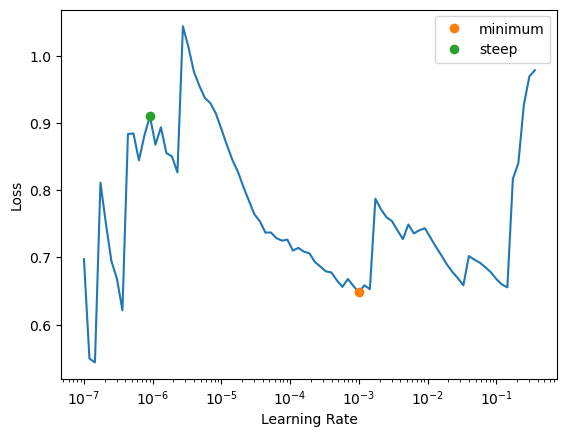

In [22]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: lr_min={lr_min}, lr_steep={lr_steep}")

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$ASCA: possibly delisted; no timezone found


Error fetching data for ASCA: No historical data available for ASCA around 2024-01-28.


$GPX: possibly delisted; no timezone found


Error fetching data for GPX: No historical data available for GPX around 2024-01-28.


$TECD: possibly delisted; no timezone found


Error fetching data for TECD: No historical data available for TECD around 2024-01-28.


$MLG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MLG: No historical data available for MLG around 2024-01-28.


$EDGW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EDGW: No historical data available for EDGW around 2024-01-28.


$VVUS: possibly delisted; no timezone found


Error fetching data for VVUS: No historical data available for VVUS around 2024-01-28.


$KNL: possibly delisted; no timezone found


Error fetching data for KNL: No historical data available for KNL around 2024-01-28.


$RVLT: possibly delisted; no timezone found


Error fetching data for RVLT: No historical data available for RVLT around 2024-01-28.


$AMNB: possibly delisted; no timezone found


Error fetching data for AMNB: No historical data available for AMNB around 2024-01-28.


$EGOV: possibly delisted; no timezone found


Error fetching data for EGOV: No historical data available for EGOV around 2024-01-28.


$AUO: possibly delisted; no timezone found


Error fetching data for AUO: No historical data available for AUO around 2024-01-28.


$HMTV: possibly delisted; no timezone found
$MOCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMTV: No historical data available for HMTV around 2024-01-28.
Error fetching data for MOCO: No historical data available for MOCO around 2024-01-28.


$SINA: possibly delisted; no timezone found


Error fetching data for SINA: No historical data available for SINA around 2024-01-28.


$MNR-B: possibly delisted; no timezone found
$BJZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MNR-B: No historical data available for MNR-B around 2024-01-28.
Error fetching data for BJZ: No historical data available for BJZ around 2024-01-28.


$VLTC: possibly delisted; no timezone found


Error fetching data for VLTC: No historical data available for VLTC around 2024-01-28.


$SYNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SYNT: No historical data available for SYNT around 2024-01-28.


$TCO: possibly delisted; no timezone found
$PSUN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TCO: No historical data available for TCO around 2024-01-28.
Error fetching data for PSUN: No historical data available for PSUN around 2024-01-28.


$HBA-G: possibly delisted; no timezone found
$JZL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HBA-G: No historical data available for HBA-G around 2024-01-28.
Error fetching data for JZL: No historical data available for JZL around 2024-01-28.


$OCZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OCZ: No historical data available for OCZ around 2024-01-28.


$ELS-C: possibly delisted; no timezone found


Error fetching data for ELS-C: No historical data available for ELS-C around 2024-01-28.


$GEQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GEQ: No historical data available for GEQ around 2024-01-28.


$JPS: possibly delisted; no timezone found


Error fetching data for JPS: No historical data available for JPS around 2024-01-28.


$CUB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for CUB: No historical data available for CUB around 2024-01-28.


$DISH: possibly delisted; no timezone found


Error fetching data for DISH: No historical data available for DISH around 2024-01-28.


$PTR: possibly delisted; no timezone found


Error fetching data for PTR: No historical data available for PTR around 2024-01-28.


$SNV-C: possibly delisted; no timezone found


Error fetching data for SNV-C: No historical data available for SNV-C around 2024-01-28.


$TAST: possibly delisted; no timezone found


Error fetching data for TAST: No historical data available for TAST around 2024-01-28.


$GZT: possibly delisted; no timezone found


Error fetching data for GZT: No historical data available for GZT around 2024-01-28.


$NMK-B: possibly delisted; no timezone found
$ADRD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NMK-B: No historical data available for NMK-B around 2024-01-28.
Error fetching data for ADRD: No historical data available for ADRD around 2024-01-28.


$MDCA: possibly delisted; no timezone found


Error fetching data for MDCA: No historical data available for MDCA around 2024-01-28.


$PGTI: possibly delisted; no timezone found


Error fetching data for PGTI: No historical data available for PGTI around 2024-01-28.


$NCU-C: possibly delisted; no timezone found


Error fetching data for NCU-C: No historical data available for NCU-C around 2024-01-28.


$QADA: possibly delisted; no timezone found


Error fetching data for QADA: No historical data available for QADA around 2024-01-28.


$NED: possibly delisted; no timezone found


Error fetching data for NED: No historical data available for NED around 2024-01-28.


$CKEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CKEC: No historical data available for CKEC around 2024-01-28.


$SAN-E: possibly delisted; no timezone found


Error fetching data for SAN-E: No historical data available for SAN-E around 2024-01-28.


$TE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CLMS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TE: No historical data available for TE around 2024-01-28.
Error fetching data for CLMS: No historical data available for CLMS around 2024-01-28.


$EAB: possibly delisted; no timezone found


Error fetching data for EAB: No historical data available for EAB around 2024-01-28.


$SLXP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SLXP: No historical data available for SLXP around 2024-01-28.


$JOY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MRH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HBHC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JOY: No historical data available for JOY around 2024-01-28.
Error fetching data for MRH: No historical data available for MRH around 2024-01-28.
Error fetching data for HBHC: No historical data available for HBHC around 2024-01-28.


$MPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MPG: No historical data available for MPG around 2024-01-28.


$WSFSL: possibly delisted; no timezone found
$TSO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WSFSL: No historical data available for WSFSL around 2024-01-28.
Error fetching data for TSO: No historical data available for TSO around 2024-01-28.


$RENN: possibly delisted; no timezone found


Error fetching data for RENN: No historical data available for RENN around 2024-01-28.


$NYLD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NYLD: No historical data available for NYLD around 2024-01-28.


$EXA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXA: No historical data available for EXA around 2024-01-28.


$JBJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JBJ: No historical data available for JBJ around 2024-01-28.


$NDP: possibly delisted; no price data found  (period=1d)


Error fetching data for NDP: single positional indexer is out-of-bounds


$RBS-M: possibly delisted; no timezone found


Error fetching data for RBS-M: No historical data available for RBS-M around 2024-01-28.


$YHOO: possibly delisted; no timezone found
$HCLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YHOO: No historical data available for YHOO around 2024-01-28.
Error fetching data for HCLP: No historical data available for HCLP around 2024-01-28.


$IQNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IQNT: No historical data available for IQNT around 2024-01-28.


$ERS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ERS: No historical data available for ERS around 2024-01-28.


$NM: possibly delisted; no timezone found


Error fetching data for NM: No historical data available for NM around 2024-01-28.


$MYJ: possibly delisted; no timezone found


Error fetching data for MYJ: No historical data available for MYJ around 2024-01-28.


$OCLR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OCLR: No historical data available for OCLR around 2024-01-28.


$POZN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for POZN: No historical data available for POZN around 2024-01-28.


$REIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for REIS: No historical data available for REIS around 2024-01-28.


$WILN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for WILN: No historical data available for WILN around 2024-01-28.


$GCVRZ: possibly delisted; no timezone found


Error fetching data for GCVRZ: No historical data available for GCVRZ around 2024-01-28.


$YDKN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KMM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YDKN: No historical data available for YDKN around 2024-01-28.
Error fetching data for KMM: No historical data available for KMM around 2024-01-28.


$ENMD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ENMD: No historical data available for ENMD around 2024-01-28.


$PSDV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSDV: No historical data available for PSDV around 2024-01-28.


$JMF: possibly delisted; no timezone found


Error fetching data for JMF: No historical data available for JMF around 2024-01-28.


$CAB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SPU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$WLB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CAB: No historical data available for CAB around 2024-01-28.
Error fetching data for SPU: No historical data available for SPU around 2024-01-28.
Error fetching data for WLB: No historical data available for WLB around 2024-01-28.


$PDII: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PDII: No historical data available for PDII around 2024-01-28.


$HMIN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HMIN: No historical data available for HMIN around 2024-01-28.


$UTEK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UTEK: No historical data available for UTEK around 2024-01-28.


$ALCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$EXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ARIA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ALCS: No historical data available for ALCS around 2024-01-28.
Error fetching data for EXL: No historical data available for EXL around 2024-01-28.
Error fetching data for ARIA: No historical data available for ARIA around 2024-01-28.


$RPRXW: possibly delisted; no timezone found
$BOFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RPRXW: No historical data available for RPRXW around 2024-01-28.
Error fetching data for BOFI: No historical data available for BOFI around 2024-01-28.


$SUSP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUSP: No historical data available for SUSP around 2024-01-28.


$ATAX: possibly delisted; no timezone found


Error fetching data for ATAX: No historical data available for ATAX around 2024-01-28.


$MDAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CIMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MDAS: No historical data available for MDAS around 2024-01-28.
Error fetching data for CIMT: No historical data available for CIMT around 2024-01-28.


$AGIIL: possibly delisted; no timezone found


Error fetching data for AGIIL: No historical data available for AGIIL around 2024-01-28.


$SCU: possibly delisted; no timezone found


Error fetching data for SCU: No historical data available for SCU around 2024-01-28.
Error fetching data for LSCC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CERS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SYBT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for AHL-PA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PBH: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NTX-C: Too Many Requests. Rate limited. Try after a while.
Error fetching data for IRC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FLY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NGG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ISIG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NSSC: Too Many Requests. Rate limited. Try after a while.
Error fetching

$AES-PC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AES-PC: No historical data available for AES-PC around 2024-01-28.


$PES: possibly delisted; no timezone found


Error fetching data for PES: No historical data available for PES around 2024-01-28.


$DCUA: possibly delisted; no timezone found


Error fetching data for DCUA: No historical data available for DCUA around 2024-01-28.


$STAN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STAN: No historical data available for STAN around 2024-01-28.


$VNRAP: possibly delisted; no timezone found


Error fetching data for VNRAP: No historical data available for VNRAP around 2024-01-28.


$CBLI: possibly delisted; no timezone found


Error fetching data for CBLI: No historical data available for CBLI around 2024-01-28.


$KMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SCL.P: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KMP: No historical data available for KMP around 2024-01-28.
Error fetching data for SCL.P: No historical data available for SCL.P around 2024-01-28.


$SFI-D: possibly delisted; no timezone found


Error fetching data for SFI-D: No historical data available for SFI-D around 2024-01-28.


$CONN: possibly delisted; no timezone found
$BMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MSCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CONN: No historical data available for CONN around 2024-01-28.
Error fetching data for BMC: No historical data available for BMC around 2024-01-28.
Error fetching data for MSCC: No historical data available for MSCC around 2024-01-28.


$VRTU: possibly delisted; no timezone found
$PETM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VRTU: No historical data available for VRTU around 2024-01-28.
Error fetching data for PETM: No historical data available for PETM around 2024-01-28.


$SNHN: possibly delisted; no timezone found


Error fetching data for SNHN: No historical data available for SNHN around 2024-01-28.


$MGLN: possibly delisted; no timezone found
$SIRO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SHPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MGLN: No historical data available for MGLN around 2024-01-28.
Error fetching data for SIRO: No historical data available for SIRO around 2024-01-28.
Error fetching data for SHPG: No historical data available for SHPG around 2024-01-28.


$GLT: possibly delisted; no timezone found


Error fetching data for GLT: No historical data available for GLT around 2024-01-28.


$MSBF: possibly delisted; no timezone found


Error fetching data for MSBF: No historical data available for MSBF around 2024-01-28.


$PKI: possibly delisted; no timezone found


Error fetching data for PKI: No historical data available for PKI around 2024-01-28.


$ATRI: possibly delisted; no timezone found


Error fetching data for ATRI: No historical data available for ATRI around 2024-01-28.


$CRDC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$FES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CRDC: No historical data available for CRDC around 2024-01-28.
Error fetching data for FES: No historical data available for FES around 2024-01-28.


$AIRM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AIRM: No historical data available for AIRM around 2024-01-28.


$KGJI: possibly delisted; no price data found  (period=1d)
$DATE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GLCB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KGJI: single positional indexer is out-of-bounds
Error fetching data for DATE: No historical data available for DATE around 2024-01-28.
Error fetching data for GLCB: No historical data available for GLCB around 2024-01-28.


$NCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NCP: No historical data available for NCP around 2024-01-28.


$NPY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NPY: No historical data available for NPY around 2024-01-28.


$FBR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$PRSS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FBR: No historical data available for FBR around 2024-01-28.
Error fetching data for PRSS: No historical data available for PRSS around 2024-01-28.


$RAS-B: possibly delisted; no timezone found
$JRCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RAS-B: No historical data available for RAS-B around 2024-01-28.
Error fetching data for JRCC: No historical data available for JRCC around 2024-01-28.


$PCBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PCBK: No historical data available for PCBK around 2024-01-28.


$DM-B: possibly delisted; no timezone found


Error fetching data for DM-B: No historical data available for DM-B around 2024-01-28.


$TICC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TICC: No historical data available for TICC around 2024-01-28.


$ADRU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ADRU: No historical data available for ADRU around 2024-01-28.


$PPL-W: possibly delisted; no timezone found
$FCVA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PPL-W: No historical data available for PPL-W around 2024-01-28.
Error fetching data for FCVA: No historical data available for FCVA around 2024-01-28.


$NYCB: possibly delisted; no timezone found


Error fetching data for NYCB: No historical data available for NYCB around 2024-01-28.


$HWCC: possibly delisted; no timezone found


Error fetching data for HWCC: No historical data available for HWCC around 2024-01-28.


$MFSF: possibly delisted; no timezone found
$GIVN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFSF: No historical data available for MFSF around 2024-01-28.
Error fetching data for GIVN: No historical data available for GIVN around 2024-01-28.


$SYX: possibly delisted; no timezone found
$END: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$REXX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SYX: No historical data available for SYX around 2024-01-28.
Error fetching data for END: No historical data available for END around 2024-01-28.
Error fetching data for REXX: No historical data available for REXX around 2024-01-28.


$QTM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QTM: No historical data available for QTM around 2024-01-28.


$CSBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CTCT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MKTO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSBK: No historical data available for CSBK around 2024-01-28.
Error fetching data for CTCT: No historical data available for CTCT around 2024-01-28.
Error fetching data for MKTO: No historical data available for MKTO around 2024-01-28.


$FINL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$EMEY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FINL: No historical data available for FINL around 2024-01-28.
Error fetching data for EMEY: No historical data available for EMEY around 2024-01-28.


$TCBIL: possibly delisted; no timezone found


Error fetching data for TCBIL: No historical data available for TCBIL around 2024-01-28.


$ORBC: possibly delisted; no timezone found


Error fetching data for ORBC: No historical data available for ORBC around 2024-01-28.


$NYMX: possibly delisted; no timezone found
$BEAV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NYMX: No historical data available for NYMX around 2024-01-28.
Error fetching data for BEAV: No historical data available for BEAV around 2024-01-28.


$TTF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$COBZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TTF: No historical data available for TTF around 2024-01-28.
Error fetching data for COBZ: No historical data available for COBZ around 2024-01-28.


$NPV-C: possibly delisted; no timezone found


Error fetching data for NPV-C: No historical data available for NPV-C around 2024-01-28.


$MJI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MJI: No historical data available for MJI around 2024-01-28.


$HWAY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for HWAY: No historical data available for HWAY around 2024-01-28.


$DXPS: possibly delisted; no timezone found


Error fetching data for DXPS: No historical data available for DXPS around 2024-01-28.


$GM.A: possibly delisted; no timezone found


Error fetching data for GM.A: No historical data available for GM.A around 2024-01-28.


$GHDX: possibly delisted; no timezone found


Error fetching data for GHDX: No historical data available for GHDX around 2024-01-28.


$MCQ: possibly delisted; no timezone found


Error fetching data for MCQ: No historical data available for MCQ around 2024-01-28.


$LFL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$PERY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LFL: No historical data available for LFL around 2024-01-28.
Error fetching data for PERY: No historical data available for PERY around 2024-01-28.


$IBCPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IBCPO: No historical data available for IBCPO around 2024-01-28.


$DVCR: possibly delisted; no timezone found
$BTH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DVCR: No historical data available for DVCR around 2024-01-28.
Error fetching data for BTH: No historical data available for BTH around 2024-01-28.


$CRESW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CRESW: No historical data available for CRESW around 2024-01-28.


$NCT-D: possibly delisted; no timezone found


Error fetching data for NCT-D: No historical data available for NCT-D around 2024-01-28.


$NID: possibly delisted; no timezone found


Error fetching data for NID: No historical data available for NID around 2024-01-28.


$FCHI: possibly delisted; no timezone found


Error fetching data for FCHI: No historical data available for FCHI around 2024-01-28.


$PACD: possibly delisted; no timezone found


Error fetching data for PACD: No historical data available for PACD around 2024-01-28.


$GRO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for GRO: No historical data available for GRO around 2024-01-28.


$AIMC: possibly delisted; no timezone found


Error fetching data for AIMC: No historical data available for AIMC around 2024-01-28.


$ANDAW: possibly delisted; no timezone found


Error fetching data for ANDAW: No historical data available for ANDAW around 2024-01-28.


$NZF-C: possibly delisted; no timezone found


Error fetching data for NZF-C: No historical data available for NZF-C around 2024-01-28.


$FCH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GTIV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FCH: No historical data available for FCH around 2024-01-28.
Error fetching data for GTIV: No historical data available for GTIV around 2024-01-28.


$MOSY: possibly delisted; no timezone found


Error fetching data for MOSY: No historical data available for MOSY around 2024-01-28.


$GDP-D: possibly delisted; no timezone found


Error fetching data for GDP-D: No historical data available for GDP-D around 2024-01-28.


$RMGN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RMGN: No historical data available for RMGN around 2024-01-28.
Error fetching data for TYY-C: Too Many Requests. Rate limited. Try after a while.
Error fetching data for STMP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MSA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LOJN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for WLBPZ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DGIT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BKEP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for GEF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EEI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ARDNA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FN: Too Many Requests. Rate limited. Try after a while.
Error fetchin

$MSCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSCI: No historical data available for MSCI around 2024-01-28.
Error fetching data for GLP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TATT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SMRT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EMC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BBSI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for XRM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ACTV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BITA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MXF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PLTM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SNBC: Too Many Requests. Rate limited. Try after a while.
Error fetching 

$TYG-B: possibly delisted; no timezone found


Error fetching data for TYG-B: No historical data available for TYG-B around 2024-01-28.


$AFH: possibly delisted; no timezone found


Error fetching data for AFH: No historical data available for AFH around 2024-01-28.


$JSD: possibly delisted; no timezone found


Error fetching data for JSD: No historical data available for JSD around 2024-01-28.


$AFC: possibly delisted; no timezone found


Error fetching data for AFC: No historical data available for AFC around 2024-01-28.


$SORL: possibly delisted; no timezone found


Error fetching data for SORL: No historical data available for SORL around 2024-01-28.


$JCP: possibly delisted; no timezone found


Error fetching data for JCP: No historical data available for JCP around 2024-01-28.


$WPCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RIT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AGNCP: unsupported operand type(s) for /: 'NoneType' and 'float'
Error fetching data for WPCS: No historical data available for WPCS around 2024-01-28.
Error fetching data for RIT: No historical data available for RIT around 2024-01-28.


$SGOC: possibly delisted; no timezone found


Error fetching data for SGOC: No historical data available for SGOC around 2024-01-28.


$RBS-S: possibly delisted; no timezone found
$CFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RBS-S: No historical data available for RBS-S around 2024-01-28.
Error fetching data for CFI: No historical data available for CFI around 2024-01-28.


$KMR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KMR: No historical data available for KMR around 2024-01-28.


$MSF: possibly delisted; no timezone found


Error fetching data for MSF: No historical data available for MSF around 2024-01-28.


$SIX: possibly delisted; no timezone found


Error fetching data for SIX: No historical data available for SIX around 2024-01-28.


$SWY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SWY: No historical data available for SWY around 2024-01-28.


$NNA: possibly delisted; no timezone found


Error fetching data for NNA: No historical data available for NNA around 2024-01-28.


$MFRI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFRI: No historical data available for MFRI around 2024-01-28.


$MDVN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MDVN: No historical data available for MDVN around 2024-01-28.


$GSVC: possibly delisted; no timezone found
$PCCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GSVC: No historical data available for GSVC around 2024-01-28.
Error fetching data for PCCC: No historical data available for PCCC around 2024-01-28.


$CTWS: possibly delisted; no timezone found
$AV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTWS: No historical data available for CTWS around 2024-01-28.
Error fetching data for AV: No historical data available for AV around 2024-01-28.


$BIRT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BIRT: No historical data available for BIRT around 2024-01-28.


$MAMS: possibly delisted; no timezone found


Error fetching data for MAMS: No historical data available for MAMS around 2024-01-28.


$HEOP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HEOP: No historical data available for HEOP around 2024-01-28.


$EIHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EIHI: No historical data available for EIHI around 2024-01-28.


$BCOM: possibly delisted; no timezone found


Error fetching data for BCOM: No historical data available for BCOM around 2024-01-28.


$MON: possibly delisted; no timezone found
$CHLN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MON: No historical data available for MON around 2024-01-28.
Error fetching data for CHLN: No historical data available for CHLN around 2024-01-28.


$NMY-C: possibly delisted; no timezone found


Error fetching data for NMY-C: No historical data available for NMY-C around 2024-01-28.


$BBNK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BBNK: No historical data available for BBNK around 2024-01-28.


$GRIF: possibly delisted; no timezone found


Error fetching data for GRIF: No historical data available for GRIF around 2024-01-28.


$ARCW: possibly delisted; no timezone found


Error fetching data for ARCW: No historical data available for ARCW around 2024-01-28.


$LUK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LUK: No historical data available for LUK around 2024-01-28.


$SCMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCMP: No historical data available for SCMP around 2024-01-28.


$GGT-B: possibly delisted; no timezone found
$APL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GGT-B: No historical data available for GGT-B around 2024-01-28.
Error fetching data for APL: No historical data available for APL around 2024-01-28.


$ENOC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ENOC: No historical data available for ENOC around 2024-01-28.


$NETE: possibly delisted; no timezone found


Error fetching data for NETE: No historical data available for NETE around 2024-01-28.


$BPOPN: possibly delisted; no timezone found
$VRNM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BPOPN: No historical data available for BPOPN around 2024-01-28.
Error fetching data for VRNM: No historical data available for VRNM around 2024-01-28.


$MXIM: possibly delisted; no timezone found


Error fetching data for MXIM: No historical data available for MXIM around 2024-01-28.


$EMCI: possibly delisted; no timezone found


Error fetching data for EMCI: No historical data available for EMCI around 2024-01-28.


Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


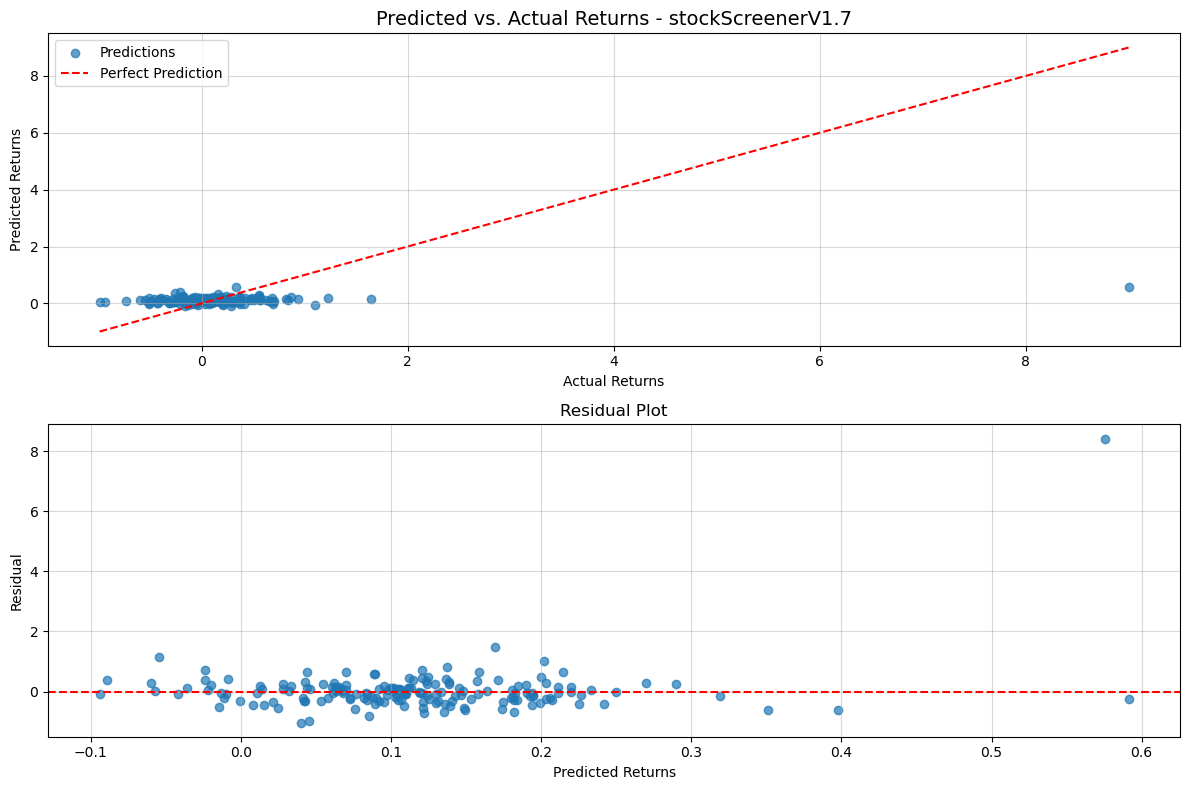

Collected 174 valid test tickers (target: 200)

Evaluation Results:
MAE: 0.328
RMSE: 0.739
R²: 0.077


In [29]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [35]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.5.pkl
stockScreenerV1.4.pkl
stockScreenerV1.6.pkl
stockScreenerV1.7.pkl
stockScreenerV1.3.pkl
stockScreenerV1.2.pkl
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl


In [36]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.7
Timestamp      2025-01-27 08:45
MAE                       0.328
RMSE                      0.739
R2                        0.077
Name: 7, dtype: object

### Load model

In [32]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [33]:
#predictionTarget = '10%'

In [34]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Drop rows with NaN values in 'EV/EBIT' or 'ROIC'
    dfPrediction = dfPrediction.dropna(subset=['EV/EBIT', 'ROIC'])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

Prediction for DRS (Unknown):
1.66%
Free money?!
